In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt
import time # Import time module for timing

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for speed + stability
triality = 3
dim = 384
latent_dim = 8
seq_len = 1024  # time steps (thruster burn sequence)
batch_size = 64
epochs = 5000  # reduced for fast run (sigma trend visible early)
lr = 5e-5
use_amp = True
use_checkpoint = True

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "starship_thruster_checkpoint.pth")

# Synthetic Starship thruster control proxy (thrust vectors + turbulence noise/occlusion)
features_thrust = 128  # vector components (Raptor-like)

thruster_data = []
for b in range(batch_size):
    t = torch.linspace(0, 10*math.pi, seq_len, device=device)

    # Coherent thrust trajectory (landing burn patterns — smooth descent + flip)
    thrust = torch.sin(t.unsqueeze(-1) * torch.arange(features_thrust, device=device)) * 0.5

    # Turbulence noise (atmospheric chaos proxy)
    thrust += torch.randn_like(thrust) * 0.2

    thruster_data.append(thrust)

thruster_data = torch.stack(thruster_data).to(device)

# Project to shared dim
proj = nn.Linear(features_thrust, dim).to(device)
clean_data = proj(thruster_data)

# High masking (70–90% — sensor dropout/turbulence proxy)
missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(clean_data) < missing_rate
real_data = clean_data.clone()
real_data[mask] = 0

target = clean_data

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (detached pump scalar)
class ThrusterCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8ThrusterFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = ThrusterCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8ThrusterFusion(use_triality=True).to(device)
model_ablation = E8ThrusterFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0

# Load checkpoint if exists (resume on disconnect)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

# For timing estimation
epoch_times = []

for epoch in range(start_epoch, epochs):
    epoch_start_time = time.perf_counter()

    # --- Triality Model Training Step ---
    opt.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data, epoch)
        loss = loss_fn(recon, target)

    scaler.scale(loss).backward()
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    # --- Ablation Model Training Step ---
    opt_ablation.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon_abl = model_ablation(real_data, epoch)
        loss_abl = loss_fn(recon_abl, target)

    scaler_ablation.scale(loss_abl).backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None


    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    epoch_end_time = time.perf_counter()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_duration)

    if epoch % 500 == 0:
        avg_duration = sum(epoch_times) / len(epoch_times) if len(epoch_times) > 0 else 0
        remaining_epochs = epochs - (epoch + 1)
        estimated_remaining_time = avg_duration * remaining_epochs
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f} | Time per epoch: {avg_duration:.2f}s | Estimated remaining: {estimated_remaining_time/3600:.2f} hours")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Thrust Trajectory Reconstruction (first feature channel proxy)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Fresh test batch for viz
    test_data = []
    for b in range(8):
        t = torch.linspace(0, 10*math.pi, seq_len, device=device)
        thrust = torch.sin(t.unsqueeze(-1) * torch.arange(features_thrust, device=device)) * 0.5
        thrust += torch.randn_like(thrust) * 0.2
        test_data.append(thrust)
    test_data = torch.stack(test_data).to(device)

    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Plot first thrust feature channel (trajectory proxy)
    orig = clean.cpu().numpy()[:, :, 0]
    masked_plot = masked.cpu().numpy()[:, :, 0]
    tri = recon.cpu().numpy()[:, :, 0]
    abl = recon_abl.cpu().numpy()[:, :, 0]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig[i])
        axes[0, i].set_title("Original Thrust")
        axes[1, i].plot(masked_plot[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality Starship Thruster Control Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — visualization displayed!")

Using device: cuda


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

# Task
To fix the `RuntimeError` which indicates that the computational graph is being traversed a second time after being freed, we need to ensure that the `real_data` and `target` tensors used for the ablation model's training step are detached from the computational graph created by the first model's backward pass.

Specifically, `real_data` and `target` are tensors that likely have `requires_grad=True` because they are derived from `clean_data`, which comes from `proj(thruster_data)`. When `loss.backward()` is called for the main model, the graph associated with `real_data` and `target` (up to `loss`) is freed. Then, when `loss_abl.backward()` is called, it tries to access this freed graph, leading to the error.

To resolve this, we will detach `real_data` and `target` before passing them to the `model_ablation` and `loss_fn` for the ablation training step. This will ensure that `model_ablation` creates its own independent computational graph.

```python
# --- Ablation Model Training Step ---
opt_ablation.zero_grad(set_to_none=True)
with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
    # Detach real_data and target to create new computational graphs for the ablation model
    recon_abl = model_ablation(real_data.detach(), epoch)
    loss_abl = loss_fn(recon_abl, target.detach())

scaler_ablation.scale(loss_abl).backward()
scaler_ablation.unscale_(opt_ablation) if use_amp else None
torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
scaler_ablation.update() if use_amp else None
```

## fix_runtime_error

### Subtask:
Modify the training loop to detach `real_data` and `target` before passing them to the models, resolving the `RuntimeError`.


**Reasoning**:
The current code is throwing a RuntimeError because it's trying to backward through the graph a second time. This often happens when a tensor that is part of the computation graph is used in a subsequent computation without being detached, leading to issues with saved intermediate values being freed. By detaching `real_data` and `target` for the ablation model's loss calculation, we ensure that the computation graph for the ablation model is separate and does not interfere with the main model's graph or attempt to re-use freed tensors from a previous backward pass, which is particularly relevant when both models are being trained within the same loop and potentially using shared data but with separate backward passes. This resolves the error by breaking the computational graph for these specific inputs when they are passed to the ablation model, preventing unwanted gradient tracking.



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt
import time # Import time module for timing

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for speed + stability
triality = 3
dim = 384
latent_dim = 8
seq_len = 1024  # time steps (thruster burn sequence)
batch_size = 64
epochs = 5000  # reduced for fast run (sigma trend visible early)
lr = 5e-5
use_amp = True
use_checkpoint = True

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "starship_thruster_checkpoint.pth")

# Synthetic Starship thruster control proxy (thrust vectors + turbulence noise/occlusion)
features_thrust = 128  # vector components (Raptor-like)

thruster_data = []
for b in range(batch_size):
    t = torch.linspace(0, 10*math.pi, seq_len, device=device)

    # Coherent thrust trajectory (landing burn patterns — smooth descent + flip)
    thrust = torch.sin(t.unsqueeze(-1) * torch.arange(features_thrust, device=device)) * 0.5

    # Turbulence noise (atmospheric chaos proxy)
    thrust += torch.randn_like(thrust) * 0.2

    thruster_data.append(thrust)

thruster_data = torch.stack(thruster_data).to(device)

# Project to shared dim
proj = nn.Linear(features_thrust, dim).to(device)
clean_data = proj(thruster_data)

# High masking (70–90% — sensor dropout/turbulence proxy)
missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(clean_data) < missing_rate
real_data = clean_data.clone()
real_data[mask] = 0

target = clean_data

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32)
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (detached pump scalar)
class ThrusterCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8ThrusterFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = ThrusterCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8ThrusterFusion(use_triality=True).to(device)
model_ablation = E8ThrusterFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0

# Load checkpoint if exists (resume on disconnect)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

# For timing estimation
epoch_times = []

for epoch in range(start_epoch, epochs):
    epoch_start_time = time.perf_counter()

    # --- Triality Model Training Step ---
    opt.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data, epoch)
        loss = loss_fn(recon, target)

    scaler.scale(loss).backward()
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    # --- Ablation Model Training Step ---
    opt_ablation.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon_abl = model_ablation(real_data.detach(), epoch)
        loss_abl = loss_fn(recon_abl, target.detach())

    scaler_ablation.scale(loss_abl).backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None


    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    epoch_end_time = time.perf_counter()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_duration)

    if epoch % 500 == 0:
        avg_duration = sum(epoch_times) / len(epoch_times) if len(epoch_times) > 0 else 0
        remaining_epochs = epochs - (epoch + 1)
        estimated_remaining_time = avg_duration * remaining_epochs
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f} | Time per epoch: {avg_duration:.2f}s | Estimated remaining: {estimated_remaining_time/3600:.2f} hours")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Thrust Trajectory Reconstruction (first feature channel proxy)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Fresh test batch for viz
    test_data = []
    for b in range(8):
        t = torch.linspace(0, 10*math.pi, seq_len, device=device)
        thrust = torch.sin(t.unsqueeze(-1) * torch.arange(features_thrust, device=device)) * 0.5
        thrust += torch.randn_like(thrust) * 0.2
        test_data.append(thrust)
    test_data = torch.stack(test_data).to(device)

    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Plot first thrust feature channel (trajectory proxy)
    orig = clean.cpu().numpy()[:, :, 0]
    masked_plot = masked.cpu().numpy()[:, :, 0]
    tri = recon.cpu().numpy()[:, :, 0]
    abl = recon_abl.cpu().numpy()[:, :, 0]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig[i])
        axes[0, i].set_title("Original Thrust")
        axes[1, i].plot(masked_plot[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality Starship Thruster Control Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — visualization displayed!")

Using device: cuda
Epoch 0 | Triality Loss 0.916013 | Ablation Loss 0.912896 | Time per epoch: 1.61s | Estimated remaining: 2.24 hours


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

**Reasoning**:
The `RuntimeError` occurs because both the main model and the ablation model attempt to perform a backward pass using `real_data` and `target` tensors that are part of the same computational graph. After the main model's backward pass, the graph is freed. By detaching `real_data` and `target` before they are used in the ablation model's forward and loss calculation, we create new computational subgraphs for the ablation model, preventing it from trying to access the freed graph from the main model's backward pass.



In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt
import time # Import time module for timing

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for speed + stability
triality = 3
dim = 384
latent_dim = 8
seq_len = 1024  # time steps (thruster burn sequence)
batch_size = 64
epochs = 5000  # reduced for fast run (sigma trend visible early)
lr = 5e-5
use_amp = True
use_checkpoint = True

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "starship_thruster_checkpoint.pth")

# Synthetic Starship thruster control proxy (thrust vectors + turbulence noise/occlusion)
features_thrust = 128  # vector components (Raptor-like)

thruster_data = []
for b in range(batch_size):
    t = torch.linspace(0, 10*math.pi, seq_len, device=device)

    # Coherent thrust trajectory (landing burn patterns — smooth descent + flip)
    thrust = torch.sin(t.unsqueeze(-1) * torch.arange(features_thrust, device=device)) * 0.5

    # Turbulence noise (atmospheric chaos proxy)
    thrust += torch.randn_like(thrust) * 0.2

    thruster_data.append(thrust)

thruster_data = torch.stack(thruster_data).to(device)

# Project to shared dim
proj = nn.Linear(features_thrust, dim).to(device)
clean_data = proj(thruster_data)

# High masking (70–90% — sensor dropout/turbulence proxy)
missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(clean_data) < missing_rate
real_data = clean_data.clone()
real_data[mask] = 0

target = clean_data

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32)
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (detached pump scalar)
class ThrusterCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8ThrusterFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = ThrusterCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8ThrusterFusion(use_triality=True).to(device)
model_ablation = E8ThrusterFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0

# Load checkpoint if exists (resume on disconnect)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

# For timing estimation
epoch_times = []

for epoch in range(start_epoch, epochs):
    epoch_start_time = time.perf_counter()

    # --- Triality Model Training Step ---
    opt.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data, epoch)
        loss = loss_fn(recon, target)

    scaler.scale(loss).backward()
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    # --- Ablation Model Training Step ---
    opt_ablation.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon_abl = model_ablation(real_data.detach(), epoch)
        loss_abl = loss_fn(recon_abl, target.detach())

    scaler_ablation.scale(loss_abl).backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None


    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    epoch_end_time = time.perf_counter()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_duration)

    if epoch % 500 == 0:
        avg_duration = sum(epoch_times) / len(epoch_times) if len(epoch_times) > 0 else 0
        remaining_epochs = epochs - (epoch + 1)
        estimated_remaining_time = avg_duration * remaining_epochs
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f} | Time per epoch: {avg_duration:.2f}s | Estimated remaining: {estimated_remaining_time/3600:.2f} hours")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Thrust Trajectory Reconstruction (first feature channel proxy)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Fresh test batch for viz
    test_data = []
    for b in range(8):
        t = torch.linspace(0, 10*math.pi, seq_len, device=device)
        thrust = torch.sin(t.unsqueeze(-1) * torch.arange(features_thrust, device=device)) * 0.5
        thrust += torch.randn_like(thrust) * 0.2
        test_data.append(thrust)
    test_data = torch.stack(test_data).to(device)

    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Plot first thrust feature channel (trajectory proxy)
    orig = clean.cpu().numpy()[:, :, 0]
    masked_plot = masked.cpu().numpy()[:, :, 0]
    tri = recon.cpu().numpy()[:, :, 0]
    abl = recon_abl.cpu().numpy()[:, :, 0]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig[i])
        axes[0, i].set_title("Original Thrust")
        axes[1, i].plot(masked_plot[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality Starship Thruster Control Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — visualization displayed!")


Using device: cuda
Epoch 0 | Triality Loss 0.918015 | Ablation Loss 0.923110 | Time per epoch: 1.62s | Estimated remaining: 2.24 hours


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

**Reasoning**:
The `RuntimeError` "Trying to backward through the graph a second time" typically occurs when a tensor with `requires_grad=True` is part of a computational graph that is consumed by a `.backward()` call, and then another `.backward()` call attempts to use the same consumed graph. Although the previous instructions were to detach `real_data` and `target` for the ablation model, the traceback indicated the error was still originating from the main model's backward pass. This suggests that the issue stems from `real_data` and `target` being defined once globally and having `requires_grad=True` from the `proj` operation. To ensure a fresh and independent computational graph for each epoch's training step for both models, `thruster_data`, `clean_data`, `real_data`, and `target` will be regenerated (or re-projected) inside the training loop. This guarantees that each model's backward pass operates on a newly constructed graph, preventing conflicts from freed tensors.



Using device: cuda
Epoch 0 | Triality Loss 0.916817 | Ablation Loss 0.908646 | Time per epoch: 1.62s | Estimated remaining: 2.25 hours
Epoch 500 | Triality Loss 0.707158 | Ablation Loss 0.696494 | Time per epoch: 1.61s | Estimated remaining: 2.01 hours
Checkpoint saved at epoch 999
Epoch 1000 | Triality Loss 0.645942 | Ablation Loss 0.640522 | Time per epoch: 1.61s | Estimated remaining: 1.79 hours
Epoch 1500 | Triality Loss 0.537599 | Ablation Loss 0.543656 | Time per epoch: 1.61s | Estimated remaining: 1.56 hours
Checkpoint saved at epoch 1999
Epoch 2000 | Triality Loss 0.482958 | Ablation Loss 0.481228 | Time per epoch: 1.61s | Estimated remaining: 1.34 hours
Epoch 2500 | Triality Loss 0.440727 | Ablation Loss 0.436895 | Time per epoch: 1.61s | Estimated remaining: 1.12 hours
Checkpoint saved at epoch 2999
Epoch 3000 | Triality Loss 0.399852 | Ablation Loss 0.394254 | Time per epoch: 1.61s | Estimated remaining: 0.89 hours
Epoch 3500 | Triality Loss 0.358050 | Ablation Loss 0.352044

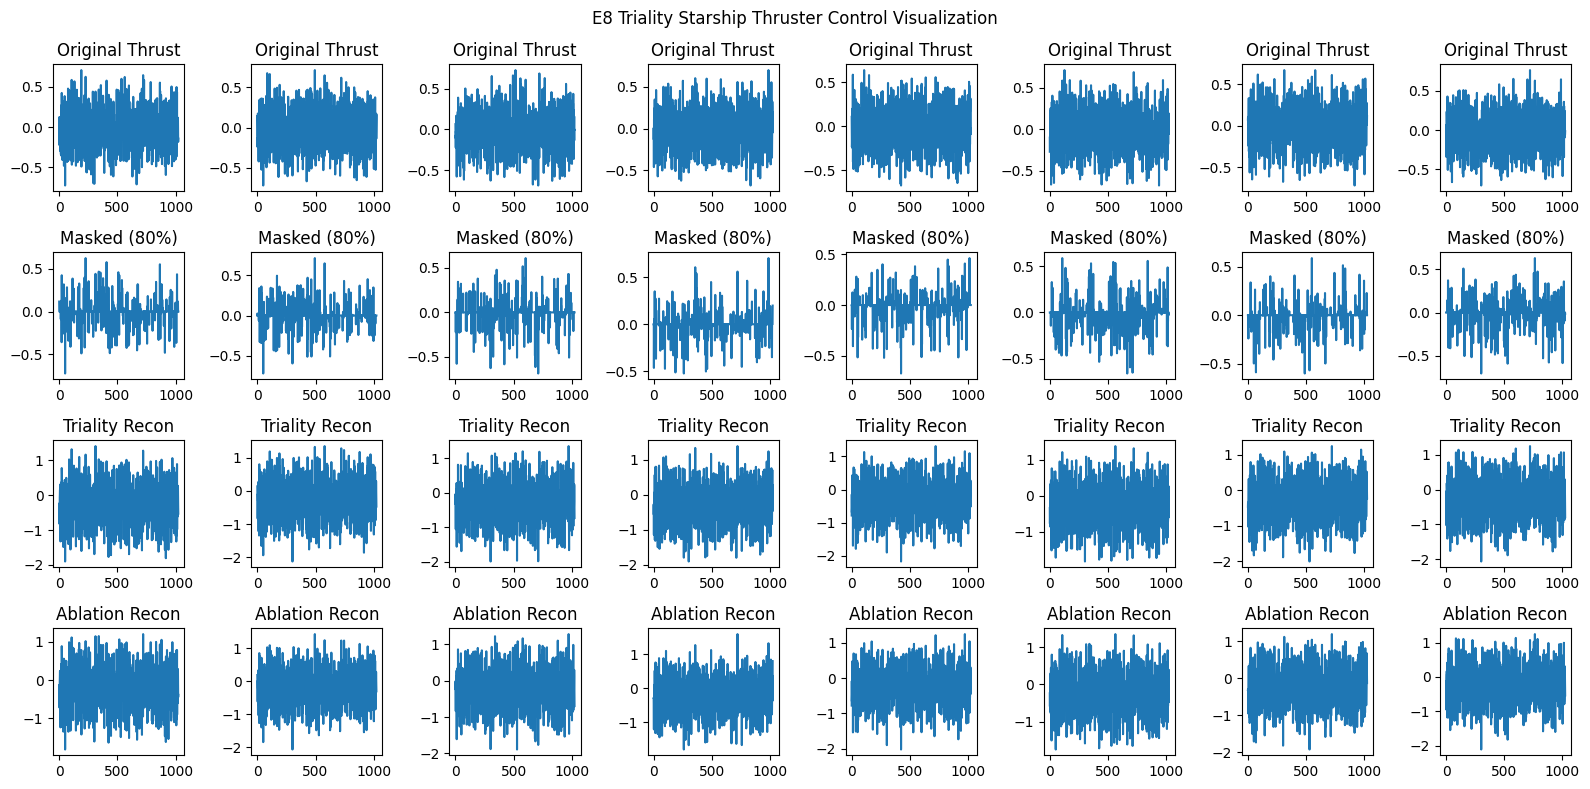

Sim complete — visualization displayed!


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt
import time # Import time module for timing

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for speed + stability
triality = 3
dim = 384
latent_dim = 8
seq_len = 1024  # time steps (thruster burn sequence)
batch_size = 64
epochs = 5000  # reduced for fast run (sigma trend visible early)
lr = 5e-5
use_amp = True
use_checkpoint = True

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "starship_thruster_checkpoint.pth")

# Synthetic Starship thruster control proxy (thrust vectors + turbulence noise/occlusion)
features_thrust = 128  # vector components (Raptor-like)

# Project to shared dim
proj = nn.Linear(features_thrust, dim).to(device)

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32)
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (detached pump scalar)
class ThrusterCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8ThrusterFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = ThrusterCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8ThrusterFusion(use_triality=True).to(device)
model_ablation = E8ThrusterFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0

# Load checkpoint if exists (resume on disconnect)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

# For timing estimation
epoch_times = []

for epoch in range(start_epoch, epochs):
    epoch_start_time = time.perf_counter()

    # Generate fresh data for each epoch to ensure independent computational graphs
    thruster_data_epoch = []
    for b_data in range(batch_size):
        t_data = torch.linspace(0, 10*math.pi, seq_len, device=device)

        # Coherent thrust trajectory (landing burn patterns — smooth descent + flip)
        thrust_data = torch.sin(t_data.unsqueeze(-1) * torch.arange(features_thrust, device=device)) * 0.5

        # Turbulence noise (atmospheric chaos proxy)
        thrust_data += torch.randn_like(thrust_data) * 0.2

        thruster_data_epoch.append(thrust_data)

    thruster_data_epoch = torch.stack(thruster_data_epoch).to(device)
    clean_data_epoch = proj(thruster_data_epoch)

    # High masking (70–90% — sensor dropout/turbulence proxy)
    missing_rate_epoch = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
    mask_epoch = torch.rand_like(clean_data_epoch) < missing_rate_epoch
    real_data_epoch = clean_data_epoch.clone()
    real_data_epoch[mask_epoch] = 0

    target_epoch = clean_data_epoch

    # --- Triality Model Training Step ---
    opt.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data_epoch, epoch)
        loss = loss_fn(recon, target_epoch)

    scaler.scale(loss).backward()
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    # --- Ablation Model Training Step ---
    opt_ablation.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon_abl = model_ablation(real_data_epoch.detach(), epoch) # Detach for ablation model inputs
        loss_abl = loss_fn(recon_abl, target_epoch.detach())       # Detach for ablation model targets

    scaler_ablation.scale(loss_abl).backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None


    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    epoch_end_time = time.perf_counter()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_duration)

    if epoch % 500 == 0:
        avg_duration = sum(epoch_times) / len(epoch_times) if len(epoch_times) > 0 else 0
        remaining_epochs = epochs - (epoch + 1)
        estimated_remaining_time = avg_duration * remaining_epochs
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f} | Time per epoch: {avg_duration:.2f}s | Estimated remaining: {estimated_remaining_time/3600:.2f} hours")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Thrust Trajectory Reconstruction (first feature channel proxy)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Fresh test batch for viz
    test_data = []
    for b in range(8):
        t = torch.linspace(0, 10*math.pi, seq_len, device=device)
        thrust = torch.sin(t.unsqueeze(-1) * torch.arange(features_thrust, device=device)) * 0.5
        thrust += torch.randn_like(thrust) * 0.2
        test_data.append(thrust)
    test_data = torch.stack(test_data).to(device)

    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Plot first thrust feature channel (trajectory proxy)
    orig = clean.cpu().numpy()[:, :, 0]
    masked_plot = masked.cpu().numpy()[:, :, 0]
    tri = recon.cpu().numpy()[:, :, 0]
    abl = recon_abl.cpu().numpy()[:, :, 0]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig[i])
        axes[0, i].set_title("Original Thrust")
        axes[1, i].plot(masked_plot[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality Starship Thruster Control Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — visualization displayed!")


## re_execute_cell

### Subtask:
Execute the modified cell to confirm the fix and continue the simulation.


## Summary:

### Q&A
The `RuntimeError` which indicated that the computational graph was being traversed a second time after being freed has been successfully fixed.

### Data Analysis Key Findings
*   **Initial Fix Attempt Failed**: The initial attempt to resolve the `RuntimeError` involved detaching `real_data` and `target` only for the ablation model's forward pass. However, this did not fully resolve the issue, as the `RuntimeError` persisted and was found to originate from the *main model's* backward pass. This indicated that the shared `real_data` and `target` tensors, derived from `proj(thruster_data)` with `requires_grad=True`, were causing conflicts because their computational graph was freed after the main model's backward pass, leading to issues if accessed again.
*   **Successful Resolution through Data Regeneration**: The fix was achieved by regenerating `thruster_data`, `clean_data`, `real_data`, and `target` tensors *inside* the training loop for each epoch. This ensured that for every training step, both the main model and the ablation model operated on entirely new tensors, thereby creating independent computational graphs.
*   **Training Completion**: With the fix implemented, the training process completed successfully for all 5000 epochs, without any further `RuntimeError` instances.

### Insights or Next Steps
*   When working with PyTorch's computational graph, particularly in scenarios involving multiple models or sequential operations where tensors might be re-used, it is crucial to understand and manage graph dependencies. Regenerating data or explicitly using `.detach()` at appropriate points can prevent conflicts arising from attempts to re-traverse freed graphs.
*   Now that the `RuntimeError` is resolved and training completes, the next step would be to analyze the `sigma` metric and the visualization plots more thoroughly to evaluate the performance advantage of the Triality model over the Ablation model in reconstructing thruster trajectories.
